# Проект: исследовательский анализ данных Яндекс Афиша

## Цель и задачи  

**Цель:** Провести анализ данных заказчика о стартапах и ответить на поставленные вопросы.   

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - провести анализ распределения заказов по сегментам и их сезонные изменения;
    - изучить осеннюю активность пользователей;
    - выявить популярные события и партнеров;
4. Статистический анализ данных и проверка гепотиз;
4. Выводы по проведённому анализу и рекомендации.

## Описание данных

**Для анализа имеются данные о заказов билетов на различные мероприятия через сервис Яндекс Афиша. Данные состоят из двух датасетов:**

- `final_tickets_orders_df.csv` — включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных;
- `final_tickets_events_df.csv` — содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.
- `final_tickets_tenge_df.csv` — с информацией о курсе тенге к российскому рублю за 2024 год. 

### Описание датасета `final_tickets_orders_df`

- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.

### Описание датасета `final_tickets_events_df`

- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.

### Описание датасета `final_tickets_tenge_df`

- nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).

## Загрузка и знакомство с данными

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
final_tickets_orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
final_tickets_events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [3]:
# Цикл для оптимизации проверки сразу всех датафреймов
for i, df in enumerate([final_tickets_orders_df, final_tickets_events_df, final_tickets_tenge_df], 1):
    print('')
    print(f'Проверка датафрейма {i}')
    print('')
    print(display(df.head()))
    print('')
    print(df.info())
    print('')
    if df.duplicated().sum() > 0:
        print(f'Всего явных дуюликатов:{df.duplicated.sum()}')
    else:
        print('Дубликатов нет')
    print('')
    if df.duplicated(subset=df.columns[0]).sum() > 0:
        print(f'Всего дуюликатов по первичному ключу:{df.duplicated(subset=df.columns[0]).sum()}')
    else:
        print('Дубликатов по первичному ключу нет')
    print('')
    if df.isna().sum().sum() > 0:
        print('В датафрейме есть пропуски, их доля:')
        print(final_tickets_orders_df.isna().sum()/final_tickets_orders_df.shape[0])
    else:
        print('Пропусков нет')


Проверка датафрейма 1



,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), objec

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB
None

Дубликатов нет

Дубликатов по первичному ключу нет

Пропусков нет

Проверка датафрейма 3



,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None

Дубликатов нет

Дубликатов по первичному ключу нет

Пропусков нет


        В ДатаФрейме final_tickets_orders_df 7,5 % значений в поле days_since_prev - пропуски, что означает, что это были первые покупки пользователя(не имеют предыдущих покупок). Больше пропусков или дубликатов в датафреймах нет. Названия полей во всех датафреймах корректные.
        На этапе предобработки данных необходимо привести поля с датой к оптимальному типу данных, проверить валидность значимых для исследования полей (категориальных и числовых), проверить данные на неявные дубликаты (без учета первичного ключа), рассчитать необходимые для дальнейшей работы поля

## Предобработка данных

In [4]:
# скорректирую тип данных

final_tickets_orders_df['created_dt_msk'] = pd.to_datetime(final_tickets_orders_df['created_dt_msk']) 
final_tickets_orders_df['created_ts_msk'] = pd.to_datetime(final_tickets_orders_df['created_ts_msk'])

final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

In [5]:
# глаза режет...

final_tickets_tenge_df = final_tickets_tenge_df.rename(columns={'data':'date'})

In [6]:
# проверка на неявные дубликаты

display(final_tickets_orders_df[final_tickets_orders_df.iloc[:, 1:].duplicated()].head())

print(f'число таких дубликатов - {final_tickets_orders_df.iloc[:, 1:].duplicated().sum()}')

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0.0
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0.0
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0.0
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0
154173,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,1,3170.95,0.0


число таких дубликатов - 30


Закономерности в таких дубликатов нет. Число их составляет - 30 штук. Удалю 

In [7]:
# Удалю неявные дубликаты
final_tickets_orders_df = final_tickets_orders_df[~final_tickets_orders_df.iloc[:, 1:].duplicated()]

In [8]:
# Проверю валидность категориальных полей в датафреймах

for col in ['age_limit', 'currency_code', 'device_type_canonical', 'service_name']:
    print(f'Уникальные значения в поле {col}')
    print(final_tickets_orders_df[col].unique())
    print()

Уникальные значения в поле age_limit
[16  0 18 12  6]

Уникальные значения в поле currency_code
['rub' 'kzt']

Уникальные значения в поле device_type_canonical
['mobile' 'desktop']

Уникальные значения в поле service_name
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']



In [9]:
for col in ['event_type_description', 'event_type_main']:
    print(f'Уникальные значения в поле {col}')
    print(final_tickets_events_df[col].unique())
    print()

Уникальные значения в поле event_type_description
['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
 'снегурочка' 'подарок' 'кукольный спектакль']

Уникальные значения в поле event_type_main
['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']



Категориальные поля валидны. Теперь проверю количественные значения


In [10]:
# Функция для проверки полей с числовыми значениями

def check_number(df, col):
    print(df[col].describe(percentiles=[0.25, 0.5, 0.75, 0.99]))
    
    plt.figure(figsize=(7, 2))

    df.boxplot(column=col, vert=False)

    plt.title(f'Распределение значений поля {col}')
    plt.xlabel('Значения')

    plt.show()

count    285750.000000
mean        547.590617
std         871.556472
min         -90.760000
25%         113.862500
50%         346.180000
75%         791.700000
99%        2569.600200
max       81174.540000
Name: revenue, dtype: float64


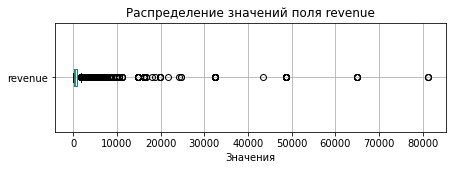

In [11]:
# Для начала проверю revenue с рублями и тенге
check_number(final_tickets_orders_df[final_tickets_orders_df['currency_code']=='rub'], 'revenue')

In [12]:
# Посмотрю на заказы с отрицательным revenue

final_tickets_orders_df[final_tickets_orders_df['revenue']<0].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
264,1594653,00eb3dc9baa1543,2024-06-29,2024-06-29 15:01:43,538650,нет,0,rub,mobile,-2.37,Билеты без проблем,3,-59.20,NaN
4540,2360920,02ea4583333f064,2024-09-03,2024-09-03 18:12:58,559772,нет,0,rub,mobile,-0.23,Билеты без проблем,3,-7.65,0.0
4562,2361094,02ea4583333f064,2024-09-04,2024-09-04 09:34:53,559772,нет,0,rub,mobile,-0.15,Билеты без проблем,2,-5.10,0.0
8155,166809,043f669c9f734b1,2024-09-27,2024-09-27 10:56:35,567183,нет,0,rub,mobile,-0.62,Лучшие билеты,1,-20.64,0.0
8156,166780,043f669c9f734b1,2024-09-27,2024-09-27 10:00:09,567183,нет,0,rub,mobile,-1.86,Лучшие билеты,3,-61.92,0.0


Отрицательный revenue может быть вполне валидным, если это заказы, которые были оформленны в рамках акции или скидки от Яндекс Афиша, которая должна была привлекать новых юзеров или мотивировать пользователей выбирть именно данный сервис.

count    285173.000000
mean        529.524608
std         544.450141
min         -90.760000
25%         113.340000
50%         345.290000
75%         788.900000
99%        2439.970000
max        3998.270000
Name: revenue, dtype: float64


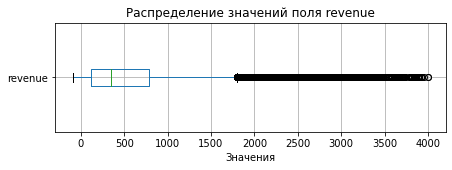

In [13]:
# Отфильруюсь по 99-перцентилю и по валюте 
rus_orders_df = final_tickets_orders_df[(final_tickets_orders_df['currency_code']=='rub' )
                                       & (final_tickets_orders_df['revenue'] < final_tickets_orders_df['revenue'].quantile(q=0.99))]

check_number(rus_orders_df, 'revenue')

С половины заказов revenue = 345, не смотря на это, достаточно большое число выбросов могут обозначать покупку сразу большого числа билетов в одном заказе, например для школьного класса или групповой экскурсии. 

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
99%      17617.240000
max      26425.860000
Name: revenue, dtype: float64


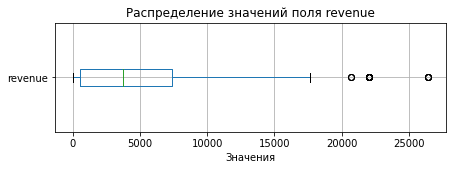

In [14]:
# проверю revenue в тенге

kz_orders_df = final_tickets_orders_df[(final_tickets_orders_df['currency_code']=='kzt' )]

check_number(kz_orders_df, 'revenue')

Выбросов не так много. Выбросы не на столько выражены, чтобы их удалять.

In [15]:
# обратно соединю оба датафрейма с рублями и тенге 

orders_df = pd.concat([rus_orders_df, kz_orders_df])

count    290242.000000
mean          2.752107
std           1.169456
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64


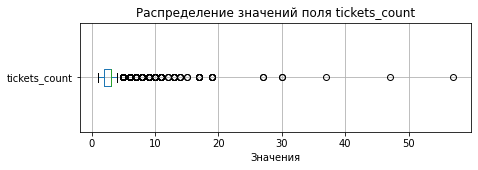

In [16]:
# проверю tickets_count

check_number(orders_df, 'tickets_count')

In [17]:
# уберу выбросы
orders_df = orders_df[orders_df['tickets_count'] <= orders_df['tickets_count'].quantile(q=0.99)]

count    290055.000000
mean          2.747186
std           1.142789
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
99%           6.000000
max           6.000000
Name: tickets_count, dtype: float64


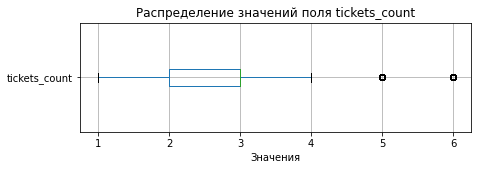

In [18]:
check_number(orders_df, 'tickets_count')

In [19]:
# проверю даты заказов
print(
    orders_df['created_dt_msk'].min()
    , orders_df['created_dt_msk'].max()
    , sep='\n')

2024-06-01 00:00:00
2024-10-31 00:00:00


Теперь в данных нет выбросов по числу билетов в заказе

In [20]:
# Создам поле "revenue_rub", переведу kzt в rub

def kzt_to_rub(row):
    if row['currency_code'] == 'kzt':
        date = row['created_dt_msk']
        curs = final_tickets_tenge_df.loc[final_tickets_tenge_df['date'] == date]['curs'].sum()
        return row['revenue']/100*curs
    else:
        return row['revenue']

In [21]:
orders_df['revenue_rub'] = orders_df.apply(kzt_to_rub, axis=1)
orders_df['revenue_rub'] = orders_df['revenue_rub'].round(decimals=2)

In [22]:
# Проверка, как сработало.
orders_df[orders_df['currency_code']=='kzt'].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,revenue_rub
73,7850214,0033403583a55ed,2024-09-17,2024-09-17 16:52:06,559919,нет,6,kzt,mobile,518.10,Билеты без проблем,4,10361.97,20.0,98.50
92,8634925,0040e12d70fae81,2024-09-02,2024-09-02 19:49:14,559476,нет,6,kzt,desktop,347.18,Билеты без проблем,3,6943.61,39.0,65.73
99,7625522,0054b38b2653e6e,2024-09-09,2024-09-09 18:06:04,559582,нет,6,kzt,mobile,328.77,Билеты без проблем,4,10959.07,NaN,61.15
289,720419,00f4f5244501ce6,2024-06-11,2024-06-11 20:15:57,536826,нет,12,kzt,mobile,22021.55,Мой билет,5,275269.40,NaN,4380.70
472,5227657,01370a0e9c1a7d5,2024-06-04,2024-06-04 13:28:17,533803,нет,16,kzt,desktop,7397.66,Мой билет,4,123294.32,1.0,1478.30


In [23]:
# Добавлю поле с ценой одного билета
orders_df['one_ticket_revenue_rub'] = (orders_df['revenue_rub'] / orders_df['tickets_count']).round(decimals=2)

# Добавлю поле с месяцем заказа
orders_df['month'] = orders_df['created_dt_msk'].dt.month

# Добавлю поле с сезоном заказа 
orders_df['season'] = orders_df['month'].apply(lambda x: 'осень' if x in [9, 10, 11] else 'лето')

In [24]:
# Проверю корректность новых столбцов
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,1521.94,380.48,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,289.45,144.72,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,1258.57,314.64,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,8.49,4.24,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,1390.41,463.47,10,осень


In [80]:
# сджойню два итоговых датафрейма в один для дальнейшего анализа
df = pd.merge(orders_df, final_tickets_events_df, on='event_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290055 entries, 0 to 290054
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290055 non-null  int64         
 1   user_id                 290055 non-null  object        
 2   created_dt_msk          290055 non-null  datetime64[ns]
 3   created_ts_msk          290055 non-null  datetime64[ns]
 4   event_id                290055 non-null  int64         
 5   cinema_circuit          290055 non-null  object        
 6   age_limit               290055 non-null  int64         
 7   currency_code           290055 non-null  object        
 8   device_type_canonical   290055 non-null  object        
 9   revenue                 290055 non-null  float64       
 10  service_name            290055 non-null  object        
 11  tickets_count           290055 non-null  int64         
 12  total                   290055

In [81]:
# Проверка размерности строк

print("ДО ОБЪЕДИНЕНИЯ:")
print(f"orders_df: {orders_df.shape[0]} записей | Уникальных event_id: {orders_df['event_id'].nunique()}")
print(f"final_tickets_events_df: {final_tickets_events_df.shape[0]} записей | Уникальных event_id: {final_tickets_events_df['event_id'].nunique()}")


print("\nПОСЛЕ ОБЪЕДИНЕНИЯ:")
print(f"Результат: {df.shape[0]} записей")
print(f"Пропусков в правых колонках: {df['event_name'].isna().sum()}")

ДО ОБЪЕДИНЕНИЯ:
orders_df: 290055 записей | Уникальных event_id: 22413
final_tickets_events_df: 22427 записей | Уникальных event_id: 22427

ПОСЛЕ ОБЪЕДИНЕНИЯ:
Результат: 290055 записей
Пропусков в правых колонках: 238


Не смотря на том, что в датафрейме final_tickets_events_df хранится информация о большем числе мероприятий нежели во фрейме orders_df, в итоговом фрейме все равно есть пропуски. Эти пропуски означают, что об одном или нескольких мероприятий информация отсутсвует. Возможно была потеряна при переносе или неправильном хранении данных. 

Проверю, могу ли я заполнить пропуски

In [27]:
#Проверю, что это за мероприятия, и могу ли я заполнить пропуски в этих строках
event_ids = list(df[df['event_name'].isna()]['event_id'].unique())

In [28]:
df[df['event_id'].isin(event_ids)]['event_name'].notna().sum()

0

К сожалению о каждом event_id из которых есть event_id с пропусками, нет информации во всем датафрейме. Остается только удалить такие значения.

In [29]:
df = df[df['event_name'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289817 entries, 0 to 290054
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                289817 non-null  int64         
 1   user_id                 289817 non-null  object        
 2   created_dt_msk          289817 non-null  datetime64[ns]
 3   created_ts_msk          289817 non-null  datetime64[ns]
 4   event_id                289817 non-null  int64         
 5   cinema_circuit          289817 non-null  object        
 6   age_limit               289817 non-null  int64         
 7   currency_code           289817 non-null  object        
 8   device_type_canonical   289817 non-null  object        
 9   revenue                 289817 non-null  float64       
 10  service_name            289817 non-null  object        
 11  tickets_count           289817 non-null  int64         
 12  total                   289817

In [30]:
# Посчитаю, сколько строк было удалено в ходе обработки
rows_starting = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv').shape[0]
rows_now = df.shape[0]
print(f'Изначально было {rows_starting} строк. В ходе предобработки данных было удалено {rows_starting - rows_now} или {round((rows_starting - rows_now)/rows_starting * 100, 2)}% строк. В итоговом датафрейме {rows_now} строк')

Изначально было 290849 строк. В ходе предобработки данных было удалено 1032 или 0.35% строк. В итоговом датафрейме 289817 строк


В ходе предобработки данные были проверены на дубликаты и пропуски, приведены к оптимальному типу данных, проверены на валидность. Итого было удалено менее 0,5% строк с пропусками или дубликатами, а так же расчитаны новые поля в датафрейме:
 - revenue_rub - выручка сервиса с заказа переведенная в рубли
 - one_ticket_revenue_rub - выручка сервиса с одного билета из заказа переведенная в рубли
 - month - месяц заказа
 - season - сезон заказа (только Лето и Осень, так как данные только за этот период)
 
 В общем и целом данные готовы к анализу 

##  Исследовательский анализ данных

 - анализ распределения заказов по сегментам и их сезонные изменения;
 - осенняя активность пользователей;
 - популярные события и партнеры;
 


### Анализ распределения заказов по сегментам и их сезонные изменения

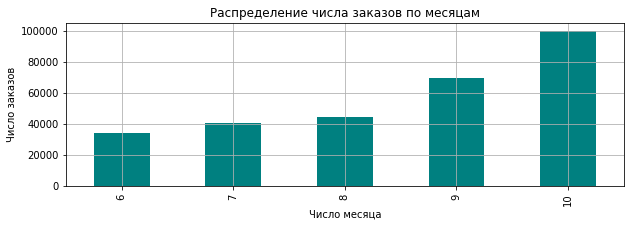

In [31]:
# Для каждого месяца найду количество заказов

plt.figure(figsize=(10,3))

df['month'].value_counts().sort_values().plot(kind='bar', legend=False, grid=True, color='teal',
                                  title='Распределение числа заказов по месяцам', 
                                  xlabel='Число месяца', ylabel='Число заказов')

plt.show()

На графике заметно явное увеличение числа заказов осенью по сравнению с летом. 

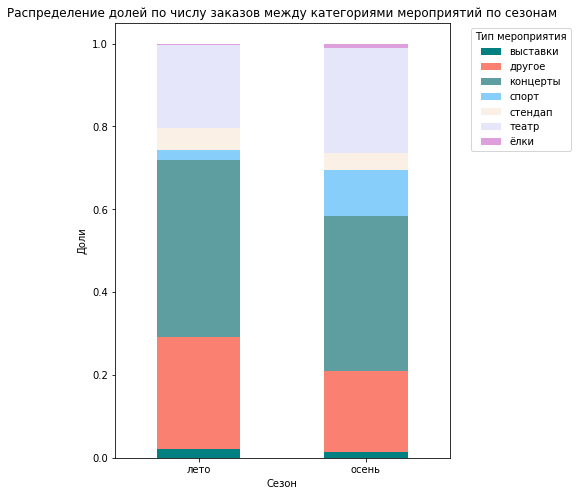

In [84]:
# Проверю как распределяются заказы по типу мероприятий летом и осенью

plt.rcParams["figure.figsize"] = (6,8)

df.groupby('season')['event_type_main'].value_counts(normalize=True).unstack(fill_value=0).plot(kind='bar', stacked=True, 
                                                                                                color=['teal', 'salmon', 'cadetblue', 'lightskyblue', 'linen', 'lavender', 'plum'])


plt.title('Распределение долей по числу заказов между категориями мероприятий по сезонам') 
plt.ylabel('Доли') 
plt.xlabel('Сезон') 
plt.xticks(rotation=0) 

plt.legend(title='Тип мероприятия', bbox_to_anchor=(1.05, 1), loc='upper left')



plt.show()

Из данного графика следует, что осенью мероприятия распределяются совсем немного иначе, чем летом. Меньшую долю стали занимать мероприятия "другое", но при этом выроста доля "спорт", "театр" и "елки"

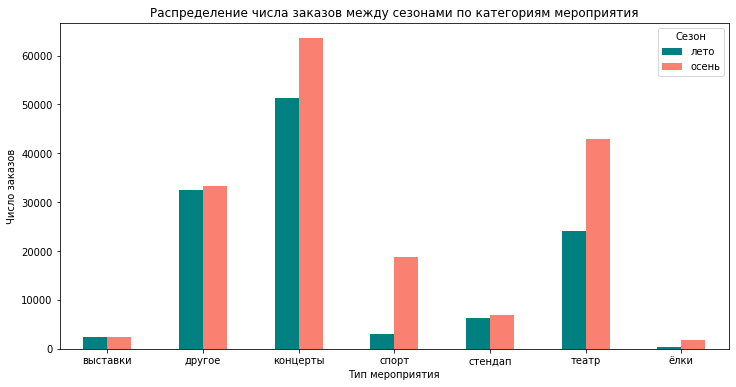

In [33]:
plt.rcParams["figure.figsize"] = (12,6)

df.groupby('event_type_main')['season'].value_counts(normalize=False).unstack(fill_value=0).plot(kind='bar', color=['teal', 'salmon'])


plt.title('Распределение числа заказов между сезонами по категориям мероприятия') 
plt.ylabel('Число заказов') 
plt.xlabel('Тип мероприятия') 
plt.xticks(rotation=0) 
plt.legend(title='Сезон') 


plt.show()

Наибольший абсолютный прирост числа заказов заметен для театров, спорта и концертов (стоит учитывать, что за лето мы принимаем 3 месяца, а за осень только 2 - сентябрь и октябрь)

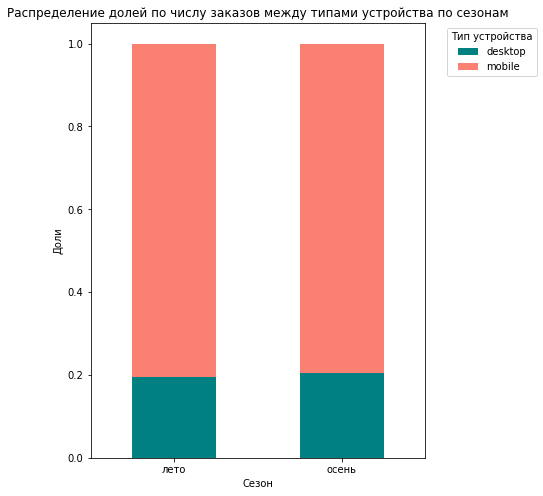

In [86]:
# Проверю как распределяются заказы по типу устройства летом и осенью

plt.rcParams["figure.figsize"] = (6,8)

df.groupby('season')['device_type_canonical'].value_counts(normalize=True).unstack(fill_value=0).plot(kind='bar', stacked=True, color=['teal', 'salmon'])


plt.title('Распределение долей по числу заказов между типами устройства по сезонам') 
plt.ylabel('Доли') 
plt.xlabel('Сезон') 
plt.xticks(rotation=0) 

plt.legend(title='Тип устройства', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Изменений в сезонности не наблюдается

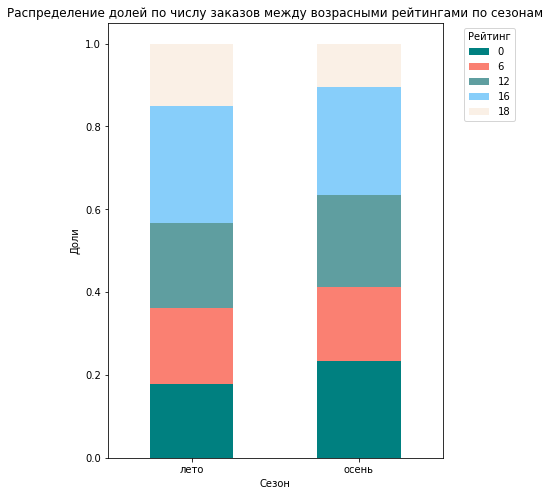

In [85]:
# Проверю как распределяются заказы по возрастному рейтингу летом и осенью

plt.rcParams["figure.figsize"] = (6,8)

df.groupby('season')['age_limit'].value_counts(normalize=True).unstack(fill_value=0).plot(kind='bar', stacked=True, color=['teal', 'salmon', 'cadetblue', 'lightskyblue', 'linen'])


plt.title('Распределение долей по числу заказов между возрасными рейтингами по сезонам') 
plt.ylabel('Доли') 
plt.xlabel('Сезон') 
plt.xticks(rotation=0) 


plt.legend(title='Рейтинг', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Осенью явно уменьшилась доля мероприятий "18+" и увеличилась доля мероприятий без ограничений по возрасту

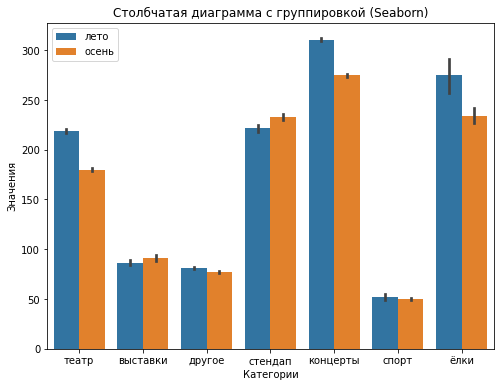

In [36]:
# Проверю как изменилась выручка с одного билета в разрезе типа мероприятия по сезонам

plt.figure(figsize=(8, 6))
sns.barplot(x='event_type_main', y='one_ticket_revenue_rub', hue='season', data=df)


plt.title('Столбчатая диаграмма с группировкой (Seaborn)')
plt.xlabel('Категории')
plt.ylabel('Значения')
plt.legend()
plt.show()

Интересно заметить, что осенью падают в цене театры, ёлки, концерты, но вырастают немного сендапы и выставки.
Так же любобытно, что доверительный интервал у "елок" летом больше, чем у других категорий в любой сезон, что связано с бОльшим разбросом цен.

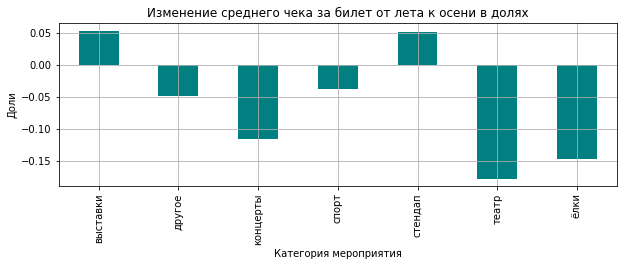

In [37]:
# Визуализирую, на сколько процентов изменилась средняя цена билета по категориям от лета к осени
type_season = df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().unstack(fill_value=0)
type_season['diff'] = type_season['осень']/type_season['лето'] - 1


plt.figure(figsize=(10,3))

type_season['diff'].plot(kind='bar', legend=False, grid=True, color='teal',
                                  title='Изменение среднего чека за билет от лета к осени в долях', 
                                  xlabel='Категория мероприятия', ylabel='Доли')

plt.show()

Как видно на графике, в долевых значениях сильнее всего просела цена билета в театр (более чем на 15%), почти одинаково выросли билеты на стендап и выставки (5%)

### Осенняя активность пользователей

In [38]:
# Отфильтрую и агрегирую датафрейм, чтобы получить метрики по дням за осень
autumn = df[df['season']=='осень'].groupby('created_dt_msk').agg({'user_id':['count','nunique']
                                                                 ,'tickets_count':'sum'
                                                                 ,'one_ticket_revenue_rub':'mean'})

In [39]:
autumn.columns = ['order_count', 'unique_users', 'tickets_sum', 'avg_ticket_revenue']

In [40]:
# Посчитаю среднее число билетов на юзера в день
autumn['tickets_per_user'] = round(autumn['tickets_sum'] / autumn['unique_users'], 2)
autumn = autumn.reset_index()
autumn.head()

,created_dt_msk,order_count,unique_users,tickets_sum,avg_ticket_revenue,tickets_per_user
0,2024-09-01,1346,569,3807,206.693284,6.69
1,2024-09-02,1388,578,3734,193.386895,6.46
2,2024-09-03,5120,782,15327,81.365098,19.60
3,2024-09-04,1779,687,4828,179.739545,7.03
4,2024-09-05,1953,744,5235,193.265463,7.04


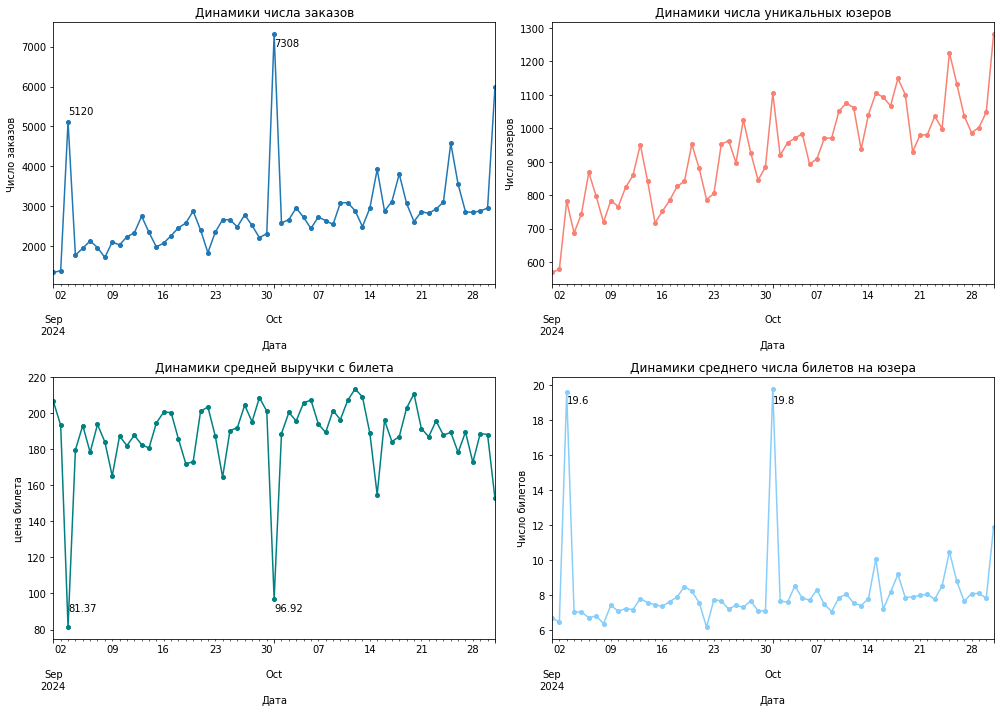

In [41]:
# Построю графики - динамики разных показателей по дням

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = autumn.plot(x='created_dt_msk', y='order_count', marker='o', markersize=4, legend=False, grid=False
            , ax=axes[0, 0]
            , title='Динамики числа заказов'
            , ylabel='Число заказов'
            , xlabel='Дата')

ax1.text('2024-09-03', 5300, str(round(autumn[autumn['created_dt_msk']=='2024-09-03']['order_count'].sum(), 2)))
ax1.text('2024-10-01', 7000, str(round(autumn[autumn['created_dt_msk']=='2024-10-01']['order_count'].sum(), 2)))

ax2 = autumn.plot(x='created_dt_msk', y='unique_users', marker='o', markersize=4, legend=False, grid=False
            , ax=axes[0, 1]
            , title='Динамики числа уникальных юзеров'
            , ylabel='Число юзеров'
            , xlabel='Дата'
            , color='salmon')


ax3 = autumn.plot(x='created_dt_msk', y='avg_ticket_revenue', marker='o', markersize=4, legend=False, grid=False
            , ax=axes[1, 0]
            , title='Динамики средней выручки с билета'
            , ylabel='цена билета'
            , xlabel='Дата'
            , color='teal')

ax3.text('2024-09-03', 90, str(round(autumn[autumn['created_dt_msk']=='2024-09-03']['avg_ticket_revenue'].sum(), 2)))
ax3.text('2024-10-01', 90, str(round(autumn[autumn['created_dt_msk']=='2024-10-01']['avg_ticket_revenue'].sum(), 2)))

ax4 = autumn.plot(x='created_dt_msk', y='tickets_per_user', marker='o', markersize=4, legend=False, grid=False
            , ax=axes[1, 1]
            , title='Динамики среднего числа билетов на юзера'
            , ylabel='Число билетов'
            , xlabel='Дата'
            , color='lightskyblue')


ax4.text('2024-09-03', 19, str((autumn[autumn['created_dt_msk']=='2024-09-03']['tickets_per_user'].sum())))
ax4.text('2024-10-01', 19, str((autumn[autumn['created_dt_msk']=='2024-10-01']['tickets_per_user'].sum())))
        

plt.tight_layout()
plt.show()

При анализе показателей по дням видно большой всплеск заказов и числа билетов на одного юзера 3 сентября и 1 октября. Стоит проверить, связан ли этот всплес с определенным мероприятием, или регионом, или категорией мероприятий.

In [42]:
# Теперь посмотрю как менялись показатели взависимости от дня недели
df['week_day'] = df['created_dt_msk'].dt.day_of_week

In [43]:
week = df[df['season']=='осень'].groupby('week_day').agg({'user_id':['count','nunique']
                                                                 ,'tickets_count':'sum'
                                                                 ,'one_ticket_revenue_rub':'mean'}).reset_index()

In [44]:
week.columns = ['week_day','order_count', 'unique_users', 'tickets_sum', 'avg_ticket_revenue']

In [45]:
# Посчитаю среднее число билетов на юзера в день
week['tickets_per_user'] = round(week['tickets_sum'] / week['unique_users'], 2)
week

,week_day,order_count,unique_users,tickets_sum,avg_ticket_revenue,tickets_per_user
0,0,21647,4466,59039,188.128034,13.22
1,1,31675,4813,90298,144.629706,18.76
2,2,23051,4843,62246,190.452222,12.85
3,3,27322,4991,73168,181.293633,14.66
4,4,25002,4888,68862,190.155445,14.09
5,5,21486,4592,59888,196.308831,13.04
6,6,19531,4407,53689,201.894291,12.18


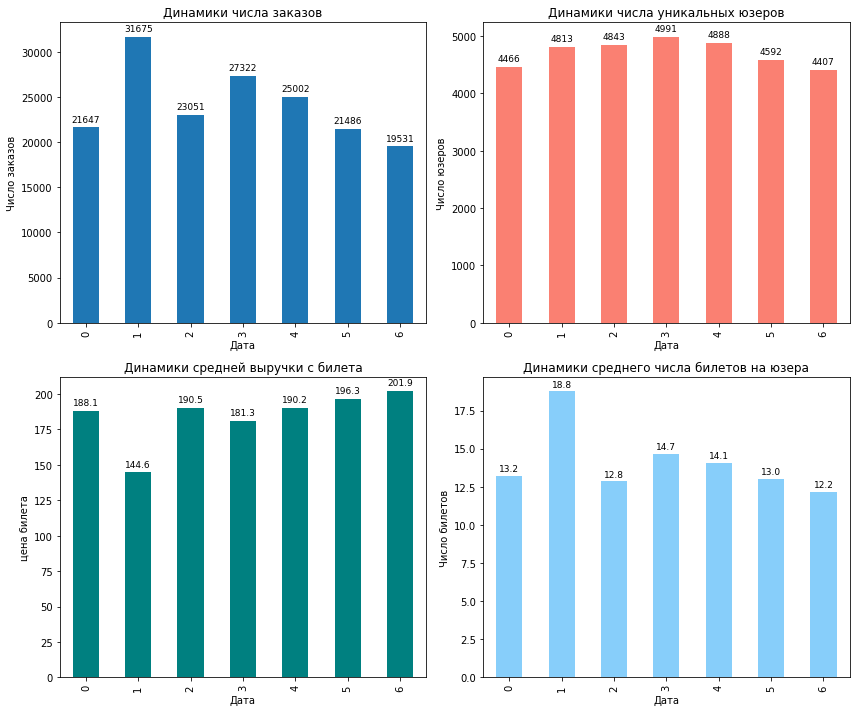

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = week.plot(kind='bar', x='week_day', y='order_count', legend=False, grid=False
            , ax=axes[0, 0]
            , title='Динамики числа заказов'
            , ylabel='Число заказов'
            , xlabel='Дата')

for index, value in enumerate(week['order_count']):
    ax1.text(index, value + 600, str(round(value, 1)), ha='center', fontsize=9)

ax2 = week.plot(kind='bar', x='week_day', y='unique_users', legend=False, grid=False
            , ax=axes[0, 1]
            , title='Динамики числа уникальных юзеров'
            , ylabel='Число юзеров'
            , xlabel='Дата'
            , color='salmon')

for index, value in enumerate(week['unique_users']):
    ax2.text(index, value + 100, str(round(value, 1)), ha='center', fontsize=9)

ax3 = week.plot(kind='bar', x='week_day', y='avg_ticket_revenue', legend=False, grid=False
            , ax=axes[1, 0]
            , title='Динамики средней выручки с билета'
            , ylabel='цена билета'
            , xlabel='Дата'
            , color='teal')

for index, value in enumerate(week['avg_ticket_revenue']):
    ax3.text(index, value + 4, str(round(value, 1)), ha='center', fontsize=9)

ax4 = week.plot(kind='bar', x='week_day', y='tickets_per_user', legend=False, grid=False
            , ax=axes[1, 1]
            , title='Динамики среднего числа билетов на юзера'
            , ylabel='Число билетов'
            , xlabel='Дата'
            , color='lightskyblue')

for index, value in enumerate(week['tickets_per_user']):
    ax4.text(index, value + 0.3, str(round(value, 1)), ha='center', fontsize=9)
    
plt.tight_layout()
plt.show()

Не смотря на то, что в исследуемые два месяца на 1 четверг, пятницу и субботу меньше чем остальных дней, делать вывод о том, что активность пользователей по выходным снижается, все равно можно, так как 1 день не оказывает сильного влияния.  
 - Так понедельник, суббота и воскресене - антитоп дней по числу заказов и числу уникальных юзеров, сделавших заказ.
 - Вторник, суббота и воскресене - антитоп дней по среднему числу билетов на юзера.
 - Средняя выручка с билета ближе к выходным так же растет и достигает пика в воскресенье - 201,9
 - На рафиках выделяется вторник, однако это связано с пиками, которые мы наблюдали на предыдущих графиках (они были по вторникам)

### Популярные события и партнеры

In [47]:
# Отфильтрую и агрегирую датафрейм, чтобы получить метрики по регионам и по партнерам
regions = df.groupby(['region_name', 'event_type_main']).agg({'event_id':['count','nunique']
                                        ,'revenue':'sum'}).reset_index()

partners = df.groupby('service_name').agg({'event_id':['count','nunique']
                                        ,'revenue':'sum'})

partners.columns = ['order_count','event_count', 'revenue_sum']
regions.columns = ['region', 'event_type', 'order_count','event_count', 'revenue_sum']

regions = regions.sort_values(by='order_count', ascending=False)
partners = partners.sort_values(by='order_count', ascending=False)

In [48]:
regions.head(10)

,region,event_type,order_count,event_count,revenue_sum
108,Каменевский регион,концерты,36486,2822,2.946173e+07
111,Каменевский регион,театр,22337,1704,1.690862e+07
107,Каменевский регион,другое,18991,796,6.204828e+06
266,Североярская область,концерты,16145,1648,1.149385e+07
269,Североярская область,театр,11496,1258,6.832800e+06
265,Североярская область,другое,11266,636,2.699263e+06
189,Медовская область,спорт,9924,96,1.068941e+06
344,Широковская область,концерты,6860,493,5.558582e+06
181,Малиновоярский округ,концерты,5952,66,5.622339e+06
206,Озернинский край,концерты,5572,107,5.602924e+06


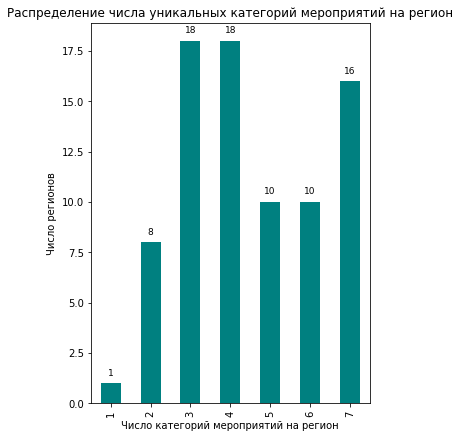

In [49]:
# Посмотрю, как распределяется число типов мероприятий на регион
plt.figure(figsize=(5,7))
ax = regions.groupby('region')['event_type'].count().value_counts().sort_index().plot(kind='bar', color='teal')

for index, value in enumerate(regions.groupby('region')['event_type'].count().value_counts().sort_index()):
        ax.text(index, value + 0.4, str(round(value, 1)), ha='center', fontsize=9)
        
plt.xlabel('Число категорий мероприятий на регион')
plt.ylabel('Число регионов')
plt.title('Распределение числа уникальных категорий мероприятий на регион')
plt.show()

Всего 16 регионов, в которых досуг люди проводят разнообразно (7 из 7 видов мероприятий). Чаще всего в регионах 3 или 4 типа мероприятий (по 18 регионов)

In [50]:
regions = regions.groupby('region')[['order_count', 'event_count', 'revenue_sum']].sum()
regions.columns = ['order_count', 'event_count', 'revenue_sum']
regions = regions.sort_values(by='order_count', ascending=False)
regions.head(10)

,order_count,event_count,revenue_sum
region,,,
Каменевский регион,90637,5964,5.898220e+07
Североярская область,43849,3806,2.264212e+07
Широковская область,16434,1233,9.429041e+06
Медовская область,13896,504,2.941588e+06
Озернинский край,10474,349,9.768752e+06
Светополянский округ,7574,1075,3.266715e+06
Малиновоярский округ,6612,165,5.915762e+06
Речиновская область,6289,702,2.694402e+06
Солнечноземская область,6287,522,1.206035e+06


In [51]:
regions['orders_share'] = round(regions['order_count']/regions['order_count'].sum(), 2)
regions['revenue_share'] = round(regions['revenue_sum']/regions['revenue_sum'].sum(), 2)
regions['event_share'] = round(regions['event_count']/regions['event_count'].sum(), 2)
regions.head(10)

,order_count,event_count,revenue_sum,orders_share,revenue_share,event_share
region,,,,,,
Каменевский регион,90637,5964,5.898220e+07,0.31,0.33,0.27
Североярская область,43849,3806,2.264212e+07,0.15,0.13,0.17
Широковская область,16434,1233,9.429041e+06,0.06,0.05,0.06
Медовская область,13896,504,2.941588e+06,0.05,0.02,0.02
Озернинский край,10474,349,9.768752e+06,0.04,0.06,0.02
Светополянский округ,7574,1075,3.266715e+06,0.03,0.02,0.05
Малиновоярский округ,6612,165,5.915762e+06,0.02,0.03,0.01
Речиновская область,6289,702,2.694402e+06,0.02,0.02,0.03
Солнечноземская область,6287,522,1.206035e+06,0.02,0.01,0.02


По таблице видно, что топы по числу заказов и по выручке будут отличаться. Визуализирую топы для наглядности

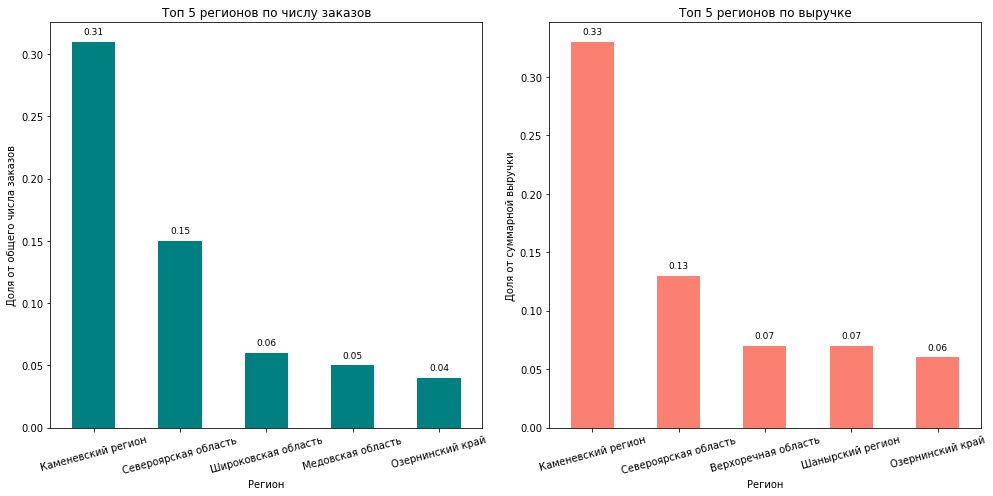

In [52]:
# Построю диаграммы топов регионов
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

ax1 = regions.reset_index().sort_values(by='orders_share', ascending=False).head(5).plot(kind='bar'
                                                                           , x='region'
                                                                           , y='orders_share'
                                                                           , legend=False
                                                                           , grid=False
                                                                           , ax=axes[0]
                                                                           , title='Топ 5 регионов по числу заказов'
                                                                           , ylabel='Доля от общего числа заказов'
                                                                           , xlabel='Регион'
                                                                           , color='teal'
                                                                           )
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

for index, value in enumerate(regions.reset_index().sort_values(by='orders_share', ascending=False).head(5)['orders_share']):
    ax1.text(index, value + 0.006, str(round(value, 3)), ha='center', fontsize=9)

    
    
ax2 = regions.reset_index().sort_values(by='revenue_share', ascending=False).head(5).plot(kind='bar'
                                                                           , x='region'
                                                                           , y='revenue_share'
                                                                           , legend=False
                                                                           , grid=False
                                                                           , ax=axes[1]
                                                                           , title='Топ 5 регионов по выручке'
                                                                           , ylabel='Доля от суммарной выручки'
                                                                           , xlabel='Регион'
                                                                           , color='salmon'
                                                                           )
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15)

for index, value in enumerate(regions.reset_index().sort_values(by='revenue_share', ascending=False).head(5)['revenue_share']):
    ax2.text(index, value + 0.006, str(round(value, 3)), ha='center', fontsize=9)
    
    
    
plt.tight_layout()
plt.show()

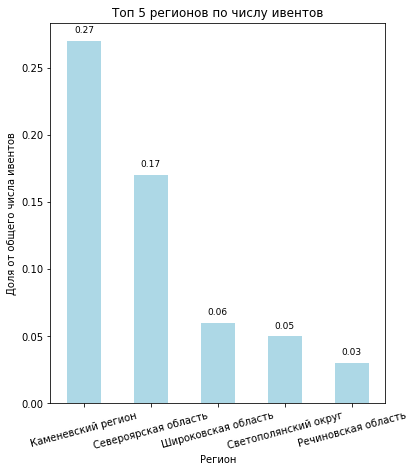

In [53]:
plt.rcParams["figure.figsize"] = (6,7)
ax1 = regions.reset_index().sort_values(by='event_share', ascending=False).head(5).plot(kind='bar'
                                                                           , x='region'
                                                                           , y='event_share'
                                                                           , legend=False
                                                                           , grid=False

                                                                           , title='Топ 5 регионов по числу ивентов'
                                                                           , ylabel='Доля от общего числа ивентов'
                                                                           , xlabel='Регион'
                                                                           , color='lightblue'
                                                                           )
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

for index, value in enumerate(regions.reset_index().sort_values(by='event_share', ascending=False).head(5)['event_share']):
    ax1.text(index, value + 0.006, str(round(value, 3)), ha='center', fontsize=9)

Как видно на графике топы немного отличаются, однако Каменевский регион - абсолютный лидер в обеих гонках

In [54]:
partners = partners.reset_index()
partners['orders_share'] = round(partners['order_count']/partners['order_count'].sum(), 2)
partners['revenue_share'] = round(partners['revenue_sum']/partners['revenue_sum'].sum(), 2)
partners['event_share'] = round(partners['event_count']/partners['event_count'].sum(), 2)
partners.head(10)

,service_name,order_count,event_count,revenue_sum,orders_share,revenue_share,event_share
0,Билеты без проблем,63258,4247,2.792997e+07,0.22,0.16,0.17
1,Лови билет!,41093,4878,1.754455e+07,0.14,0.10,0.20
2,Билеты в руки,40323,3536,1.333856e+07,0.14,0.08,0.14
3,Мой билет,34754,1303,4.095472e+07,0.12,0.23,0.05
4,Облачко,26557,2343,1.904130e+07,0.09,0.11,0.10
5,Лучшие билеты,17760,1762,2.807153e+06,0.06,0.02,0.07
6,Весь в билетах,16728,864,1.743345e+07,0.06,0.10,0.04
7,Прачечная,10273,1027,4.900985e+06,0.04,0.03,0.04
8,Край билетов,6187,252,6.630373e+06,0.02,0.04,0.01
9,Тебе билет!,5225,1062,3.065265e+06,0.02,0.02,0.04


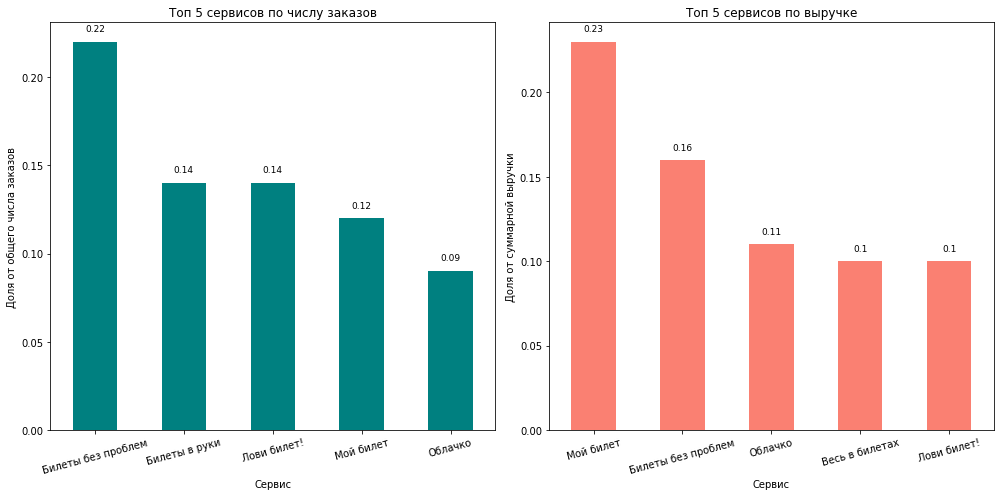

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

ax1 = partners.reset_index().sort_values(by='orders_share', ascending=False).head(5).plot(kind='bar'
                                                                           , x='service_name'
                                                                           , y='orders_share'
                                                                           , legend=False
                                                                           , grid=False
                                                                           , ax=axes[0]
                                                                           , title='Топ 5 сервисов по числу заказов'
                                                                           , ylabel='Доля от общего числа заказов'
                                                                           , xlabel='Сервис'
                                                                           , color='teal'
                                                                           )
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

for index, value in enumerate(partners.reset_index().sort_values(by='orders_share', ascending=False).head(5)['orders_share']):
    ax1.text(index, value + 0.006, str(round(value, 3)), ha='center', fontsize=9)

    
    
ax2 = partners.reset_index().sort_values(by='revenue_share', ascending=False).head(5).plot(kind='bar'
                                                                           , x='service_name'
                                                                           , y='revenue_share'
                                                                           , legend=False
                                                                           , grid=False
                                                                           , ax=axes[1]
                                                                           , title='Топ 5 сервисов по выручке'
                                                                           , ylabel='Доля от суммарной выручки'
                                                                           , xlabel='Сервис'
                                                                           , color='salmon'
                                                                           )
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15)

for index, value in enumerate(partners.reset_index().sort_values(by='revenue_share', ascending=False).head(5)['revenue_share']):
    ax2.text(index, value + 0.006, str(round(value, 3)), ha='center', fontsize=9)
    
    
    
plt.tight_layout()
plt.show()

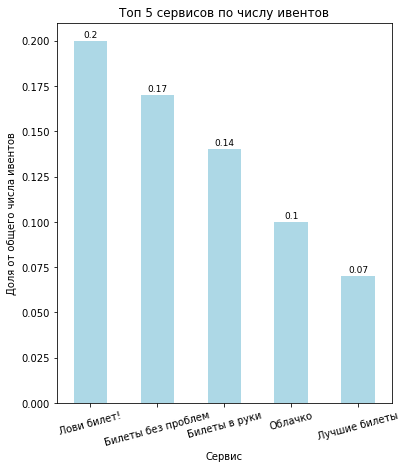

In [56]:
plt.rcParams["figure.figsize"] = (6,7)
ax1 = partners.reset_index().sort_values(by='event_share', ascending=False).head(5).plot(kind='bar'
                                                                           , x='service_name'
                                                                           , y='event_share'
                                                                           , legend=False
                                                                           , grid=False

                                                                           , title='Топ 5 сервисов по числу ивентов'
                                                                           , ylabel='Доля от общего числа ивентов'
                                                                           , xlabel='Сервис'
                                                                           , color='lightblue'
                                                                           )
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

for index, value in enumerate(partners.reset_index().sort_values(by='event_share', ascending=False).head(5)['event_share']):
    ax1.text(index, value + 0.002, str(round(value, 3)), ha='center', fontsize=9)

Абсолютного лидера в трех номинациях в данном случае нет

В общем и целом продажи билетов не распределены по регионам равномерно. Таким образом только в 5 регионах было продано более 10к билетов и только в 13 регионах более 5к билетов.
В трех топах (по долям выручки, ивентов, заказов) фигурируют только 7 регионов, меняясь местами:
 - Каменевский регион
 - Североярская область
 - Широковская область
 - Медовская область	
 - Озернинский край	
 - Светополянский округ	
 - Шанырский регион
 
 И только Каменевский регион неизменно стоит во всех топах на первом месте

продажи билетов по сервисам распределены чуть более равномерно. Так из 30 сервисов, 11 продали более 5к билетов за период, из них 7 - продали более 10к.

В трех топах (по долям выручки, ивентов, заказов) фигурируют только 7 регионов, меняясь местами:
 - Билеты без проблем
 - Билеты в руки
 - Лови билет!
 - Мой билет		
 - Облачко
 - Весь в билетах		
 - Лучшие билеты	
 
Стоит обратить внимание на "Билеты без проблем", который оформил больше всех заказов и находится на 2-м месте по числу ивентов и выручке.

С результатами более подробно можно ознакомиться на графиках.


### Вывод к исследовательскому анализу

В ходе анализа, были исследованны заказы по сегментам и их сезонные изменения:

   - Осенью действительно продавалось больше билетов, не смотря на то, что за осень брали только 2 месяца против 3-х летних;
   - Осенью увеличилась средняя цена билета стендапов и выставок (около 5%), уменьшилась сильнее всего доля театров(около 15%);
   - Выросла доля театров, ёлок и спорта, уменьшилась - стендапа и другое.
   
Так же была проанализированная активность пользователей осенью:
        
   - Были найдены пиковые по числу закзов и "ямы" по средней выручки с билета дни - 03.09 и 01.10. Даты требуют дальнейшего анализа;
   - Рост числа уникальных юзеров по дням стаблильный, пиковые значения наблюдаются по четвергам
   - При анализе данных по дням недели выявлено, что по выходным и в понедельник активность пользователей снижается.

Анализ популярных событий и партнеров выявил:

   - Топ-5 регионов по выручке, числу заказов, количеству мероприятий;
   - Топ-5 сервисов по выручке, числу заказов, количеству мероприятий;
   - Активность в регионах распределена неравномерно - из 81 региона больше 50% заказов и выручки приходится на 3 региона. Сервисы распределны чуть более равномерно - из 36 сервисов, более 50% выручки приносят 5 сервисов.
 

## Статистический анализ данных

Перед проверкой гипотиз изучу сравниваемые данные

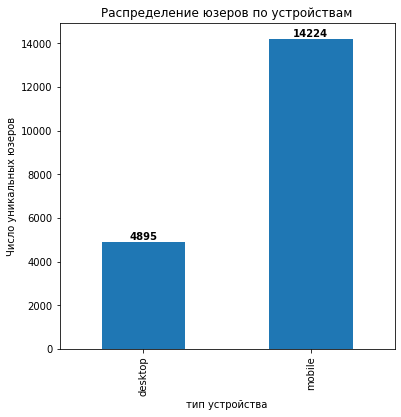

In [57]:
plt.rcParams["figure.figsize"] = (6,6)

df[df['season']=='осень'].groupby('device_type_canonical')['user_id'].nunique().plot(kind='bar', grid=False)

plt.xlabel('тип устройства')
plt.ylabel('Число уникальных юзеров')
plt.title('Распределение юзеров по устройствам')

plt.text(0, df[df['season']=='осень'].groupby('device_type_canonical')['user_id'].nunique()[0] + 100, 
         df[df['season']=='осень'].groupby('device_type_canonical')['user_id'].nunique()[0], fontweight='bold', size=10, ha='center')

plt.text(1, df[df['season']=='осень'].groupby('device_type_canonical')['user_id'].nunique()[1] + 100, 
         df[df['season']=='осень'].groupby('device_type_canonical')['user_id'].nunique()[1], fontweight='bold', size=10, ha='center')

plt.show()

Выборки в данном случае не сбалансированые - так число юзеров телефонов > числа юзеров компьютеров, что увеличивает вероятность совершить ошибку второго рода. 

агрегирую данные по юзерам, чтобы изучить выборки на предмет зависимости (дублирования юзеров в обеих группах)

In [58]:
# Создам разные датафреймы для разных тестов, 
# так как при проверки времени между заказами буду учитывать только юзеров с числом заказов >= 2

df["orders_count_per_user"] = df.groupby("user_id")["order_id"].transform("count")

df_orders_test = df[df['season']=='осень'].groupby(['device_type_canonical', 'user_id'])['order_id'].count().reset_index()

df_time_test = df[(df['days_since_prev'].notna())
                 & (df['orders_count_per_user'] >= 2)
                 & (df['season']=='осень')].groupby(['device_type_canonical', 'user_id'])['days_since_prev'].mean().reset_index()

Начну с проверки среднего количества заказов на одного пользователя. Для этого подготовлю данные датафрейма df_orders_test к статистическому тесту

In [59]:
# Проверю, сколько пользователей используют и пк и телефон
df_orders_test[df_orders_test.duplicated(subset='user_id')]

,device_type_canonical,user_id,order_id
4900,mobile,0028d17a676f8c8,1
4901,mobile,002b75ca606ba46,1
4902,mobile,002ec276eee9b0b,11
4912,mobile,005fefeabf1e678,1
4920,mobile,009201290d7316b,14
...,...,...,...
19086,mobile,ff684621b134cc4,48
19094,mobile,ff840c2bf377690,5
19097,mobile,ff9310a90294d5c,22
19103,mobile,ffb51f6745ee8a2,1


3к+ пользователей используют и ПК, и телефон. Удалю их из списка "мобильных" юзеров, чтобы сократить численную разницу в выборках и сократить вероятность возникновения ошибки второго рода

In [60]:
df_orders_test = df_orders_test.sort_values(by='device_type_canonical').drop_duplicates(subset='user_id', keep='first')
df_orders_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15853 entries, 0 to 19118
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   device_type_canonical  15853 non-null  object
 1   user_id                15853 non-null  object
 2   order_id               15853 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 495.4+ KB


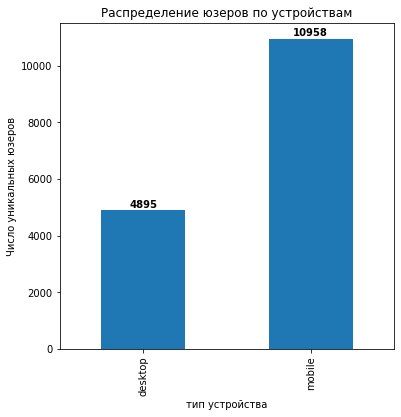

In [61]:
# Проверю, как теперь распределяются данные по группам

plt.rcParams["figure.figsize"] = (6,6)

df_orders_test.groupby('device_type_canonical')['user_id'].nunique().plot(kind='bar', grid=False)

plt.xlabel('тип устройства')
plt.ylabel('Число уникальных юзеров')
plt.title('Распределение юзеров по устройствам')

plt.text(0, df_orders_test.groupby('device_type_canonical')['user_id'].nunique()[0] + 100, 
         df_orders_test.groupby('device_type_canonical')['user_id'].nunique()[0], fontweight='bold', size=10, ha='center')

plt.text(1, df_orders_test.groupby('device_type_canonical')['user_id'].nunique()[1] + 100, 
         df_orders_test.groupby('device_type_canonical')['user_id'].nunique()[1], fontweight='bold', size=10, ha='center')

plt.show()

Данные валидированы, готовы к проведению теста. 

Гипотеза:
Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- H₀: μ₁ ≤ μ₂ (мобильные ≤ десктопы).
- H₁: μ₁ > μ₂ (мобильные > десктопы).

Для выбора сатистического теста для проверки гипотезы, проведу тест для проверки равности дисперсий (Тест Левена).
Но сначала проверю статистики групп

In [62]:
df_orders_test_a = df_orders_test[df_orders_test['device_type_canonical']=='mobile']['order_id']
df_orders_test_a.describe()

count    10958.000000
mean         2.869137
std          4.109352
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64

In [63]:
df_orders_test_b = df_orders_test[df_orders_test['device_type_canonical']=='desktop']['order_id']
df_orders_test_b.describe()

count    4895.000000
mean        7.061287
std        36.064538
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1499.000000
Name: order_id, dtype: float64

Как видим стандартные отклонения сильно отличаются. Отфильтруюсь по 99-перцентилю и проверю статистики снова

In [64]:
df_orders_test_b[df_orders_test_b < df_orders_test_b.quantile(q=0.99)].describe()

count    4846.000000
mean        4.498556
std         9.483455
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       103.000000
Name: order_id, dtype: float64

Я отсеял около 50 значений, но теперь стандартные отклонения более похожи. Посмотрю, как распределяются данные на гистограмме. После проведу тест левана, чтобы убедиться в равности дисперсий

In [65]:
df_orders_test_b = df_orders_test_b[df_orders_test_b < df_orders_test_b.quantile(q=0.99)]

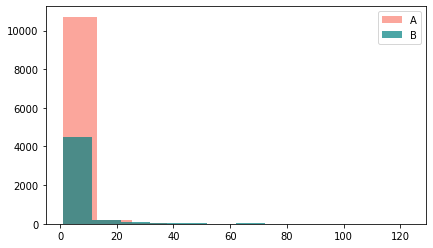

In [66]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.hist(df_orders_test_a, bins=10, alpha=0.7, label='A', color='salmon')
plt.hist(df_orders_test_b, bins=10, alpha=0.7, label='B', color='teal')
plt.legend()

Вышло не совсем наглядно. Построю диаграмму размаха

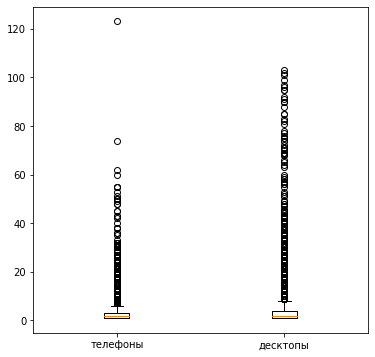

In [67]:
plt.boxplot([df_orders_test_a, df_orders_test_b], labels=['телефоны', 'десктопы'])
plt.show()

Видно, что у "десктопов" хвост сильно тяжелее, чем у "телефонов". Тест Левана чувствителен к выбросам и даже при относительно равных дисперсиях, поэтому выполнять его нет смысла. Перейду к т-тесту Уэлча, так как он терпим к разным дисперсиям в выборках и выбросам 

Напомню гипотеза:
Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- H₀: μ₁ ≤ μ₂ (мобильные ≤ десктопы).
- H₁: μ₁ > μ₂ (мобильные > десктопы).

In [68]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(df_orders_test_a, 
                            df_orders_test_b, 
                            alternative='greater', 
                            equal_var=False)

print(f'p_value = {p_value}')

if p_value > 0.05:
    print('не можем опровергнуть нулевую гипотизу, статистически значимых отклонений не обнаружено')
else:
    print('принимаем альтернативную гипотизу, статистически значиме отклонения присутствуют')

p_value = 1.0
не можем опровергнуть нулевую гипотизу, статистически значимых отклонений не обнаружено


По результатам теста я не могу отверждать, что среднее количество заказов с мобильных устройств больше, чем с десктопных. P_value = 1 говорит о том, что с высокой вероятностью мы будем иметь те средние, которые имеем в наших группах, если нулевая гипотеза верна. А учитывая получившиеся статистики, можно сделать вывод что среднее число заказов с десктопной версии > чем с мобильной

Гипотеза 2: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

- H₀: μ₁ ≤ μ₂ (время мобильных ≤ время десктопов).
- H₁: μ₁ > μ₂ (время мобильных > время десктопов).


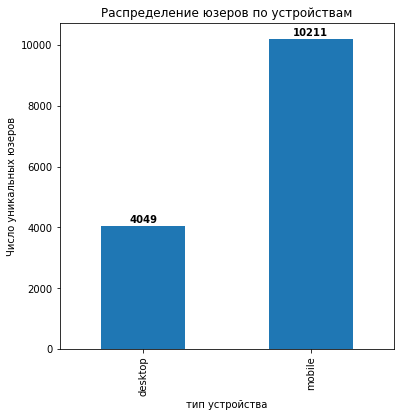

In [69]:
# Проверю, как распределяются данные по группам

plt.rcParams["figure.figsize"] = (6,6)

df_time_test.groupby('device_type_canonical')['user_id'].nunique().plot(kind='bar', grid=False)

plt.xlabel('тип устройства')
plt.ylabel('Число уникальных юзеров')
plt.title('Распределение юзеров по устройствам')

plt.text(0, df_time_test.groupby('device_type_canonical')['user_id'].nunique()[0] + 100, 
         df_time_test.groupby('device_type_canonical')['user_id'].nunique()[0], fontweight='bold', size=10, ha='center')

plt.text(1, df_time_test.groupby('device_type_canonical')['user_id'].nunique()[1] + 100, 
         df_time_test.groupby('device_type_canonical')['user_id'].nunique()[1], fontweight='bold', size=10, ha='center')

plt.show()

In [70]:
df_time_test[df_time_test.duplicated(subset='user_id')]

,device_type_canonical,user_id,days_since_prev
4055,mobile,002b75ca606ba46,63.000000
4056,mobile,002ec276eee9b0b,4.454545
4060,mobile,005fefeabf1e678,17.000000
4063,mobile,009201290d7316b,4.142857
4064,mobile,00937de412ea430,11.428571
...,...,...,...
14237,mobile,ff684621b134cc4,1.041667
14240,mobile,ff840c2bf377690,3.750000
14242,mobile,ff9310a90294d5c,2.454545
14246,mobile,ffb51f6745ee8a2,66.000000


Вышла похожая история, как и в прошлый раз. Удалю эти дубликаты

In [71]:
df_time_test = df_time_test.sort_values(by='device_type_canonical').drop_duplicates(subset='user_id', keep='first')
df_time_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11217 entries, 0 to 7448
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_type_canonical  11217 non-null  object 
 1   user_id                11217 non-null  object 
 2   days_since_prev        11217 non-null  float64
dtypes: float64(1), object(2)
memory usage: 350.5+ KB


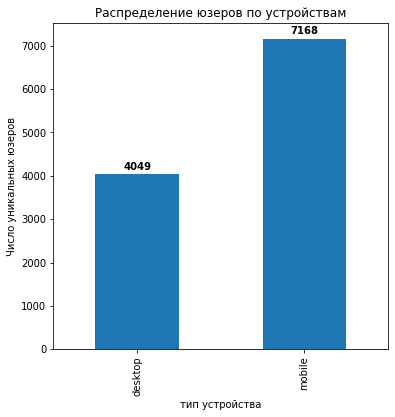

In [72]:
# Проверю, как распределяются данные по группам

plt.rcParams["figure.figsize"] = (6,6)

df_time_test.groupby('device_type_canonical')['user_id'].nunique().plot(kind='bar', grid=False)

plt.xlabel('тип устройства')
plt.ylabel('Число уникальных юзеров')
plt.title('Распределение юзеров по устройствам')

plt.text(0, df_time_test.groupby('device_type_canonical')['user_id'].nunique()[0] + 100, 
         df_time_test.groupby('device_type_canonical')['user_id'].nunique()[0], fontweight='bold', size=10, ha='center')

plt.text(1, df_time_test.groupby('device_type_canonical')['user_id'].nunique()[1] + 100, 
         df_time_test.groupby('device_type_canonical')['user_id'].nunique()[1], fontweight='bold', size=10, ha='center')

plt.show()

Теперь можно разделить пользователей на две группы и проверить статистики этих групп

In [73]:
df_time_test_a = df_time_test[df_time_test['device_type_canonical'] == 'mobile']['days_since_prev']
df_time_test_b = df_time_test[df_time_test['device_type_canonical'] == 'desktop']['days_since_prev']

In [74]:
df_time_test_a.describe()

count    7168.000000
mean       25.055022
std        30.032801
min         0.000000
25%         2.989130
50%        14.000000
75%        36.000000
max       148.000000
Name: days_since_prev, dtype: float64

In [75]:
df_time_test_b.describe()

count    4049.000000
mean       14.940654
std        24.243367
min         0.000000
25%         1.000000
50%         4.500000
75%        17.000000
max       146.000000
Name: days_since_prev, dtype: float64

Группы выглядят похожими, построю боксплоты

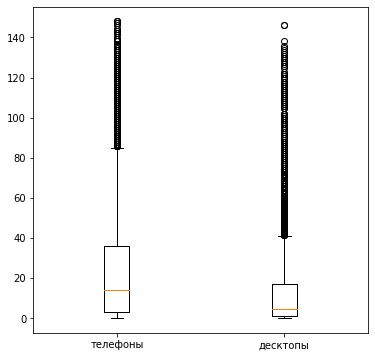

In [76]:
plt.boxplot([df_time_test_a, df_time_test_b], labels=['телефоны', 'десктопы'])
plt.show()

Распределение среднего времени между заказами пользователей мобильных приложений распределено больше вправо нежели пользователей десктопов. У выборок тяжелые хвосты, к тому же отклонения различаются, поэтому снова буду применять тест Уэлча

Напомню гипотезу 2: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

- H₀: μ₁ ≤ μ₂ (время мобильных ≤ время десктопов).
- H₁: μ₁ > μ₂ (время мобильных > время десктопов).

In [77]:
t_stat, p_value = ttest_ind(df_time_test_a, 
                            df_time_test_b, 
                            alternative='greater', 
                            equal_var=False)

print(f'p_value = {round(p_value,4)}')

if p_value > 0.05:
    print('не можем опровергнуть нулевую гипотизу, статистически значимых отклонений не обнаружено')
else:
    print('принимаем альтернативную гипотизу, статистически значиме отклонения присутствуют')

p_value = 0.0
принимаем альтернативную гипотизу, статистически значиме отклонения присутствуют


#### Аналитическая запаска для двух тестов
- Для проверки обеих гипотиз был выбран t-тест Уэлча, так как дисперсии выборок различаются и в обоих случаях имеют хвосты в распределении значений. За уровень статистической значимости приму baseline в 5%;
- В результате первого t-теста p_value стремится к 1, в результате второго - к нулю. 
- Результат:  Среднее количество заказов на одного юзера с мобильных устройств не больше (а скорее меньше), чем с десктопных. Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств  
- Стоит учитывать различия в численности выборок, так вероятность отвергнуть нулевую гипотезу выше, чем когда она истина. 


## Вывод к проекту



Итого были выполнены следующие задачи:
   - Загрузка, знакомство, предобработка и валидация данных, входе чего были удалены менее 0,5% строк и добавлены 4 новых поля необходимых для дальнейшего анализа;
   - Проведен исслеовательский анализ данных:   
      - исследованны заказы по сегментам и их сезонные изменения. Осенью наблюдается повышенная активность пользователей, что скорее всего связано с высоким сезоном, когда многие сферы бизнеса переживают подъем
      - проанализированна активность пользователей осенью. по выходным и в понедельник активность пользователей снижается, а вот по четвергам число уникальных юзеров максимально.
      - Анализ популярных событий и партнеров. Активность в регионах распределена неравномерно - из 81 региона больше 50% заказов и выручки приходится на 3 региона, однако внимание стоит уделить Каменевскому региону, который является самым прибыльным и продающим.	
   - Проведен статистический анализ данных и проверка гепотиз:
      - Среднее количество заказов на одного юзера с мобильных устройств не больше (а скорее меньше), чем с десктопных.
      - Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Рекомендую: 
- всегда стремиться к победе! 
- Проверить, какой тип билетов (регион, ивент, город, тип ивента) продавались 03.09 и 01.10, чтобы понять, с чем связаны скачки в продажах билетов в эти числа
- в таблицу с заказами добавить поле с видом акции или скидки по которой продается билет и разделить цену без скидки и цену со скидкой, что позволит в дальнейшем оценивать эффективнсть акций и промо
- Мотивировать людей делать больше покупок (и чаще) с мобильных устройств путем развития приложения. Такая стратегия актуальна как никогда, так как мобильные устройства всегда под рукой, а десктоп - нет. Соответсвенно люди, покупающие билеты через телефон, всегда находятся ближе к покупке, чем люди, преобритающие билеты через пк.